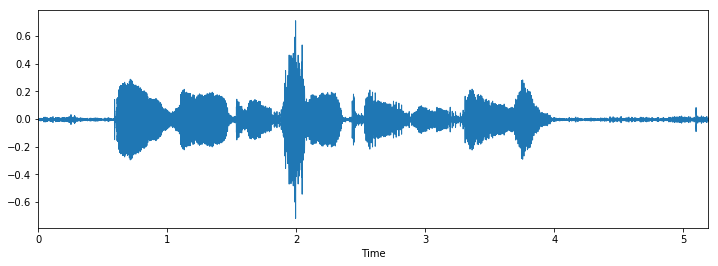

In [1]:

import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

wave, fs = librosa.load('multimedia.wav', sr=None)
plt.figure(figsize=(12, 4))
librosa.display.waveplot(wave, sr=fs)
plt.show()


In [2]:
frame_len = int(20 * fs /1000) # 20ms
frame_shift = int(10 * fs /1000) # 10ms
# calculate RMS
rms = librosa.feature.rmse(wave, frame_length=frame_len, hop_length=frame_shift)
rms = rms[0]
rms = librosa.util.normalize(rms, axis=0)

# calculate zero-crossing rate
zrc = librosa.feature.zero_crossing_rate(wave, frame_length=frame_len, hop_length=frame_shift, threshold=0)
zrc = zrc[0]

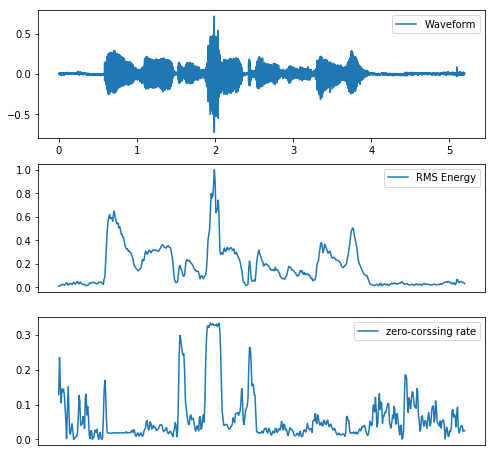

In [3]:
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
t = np.linspace(0, len(wave)/fs, len(wave))
plt.plot(t, wave, label='Waveform')
plt.legend(loc='best')

plt.subplot(3, 1, 2)
plt.plot(rms.T, label='RMS Energy')
plt.xticks([])
plt.legend(loc='best')

plt.subplot(3, 1, 3)
plt.plot(zrc.T, label='zero-corssing rate')
plt.xticks([])
plt.legend(loc='best')
plt.show()


In [4]:
frame_len = int(25 * fs /1000) # 20ms
frame_shift = int(10 * fs /1000) # 10ms
frames = librosa.util.frame(wave, frame_length=frame_len, hop_length=frame_shift)

pitches, magnitudes = librosa.core.piptrack(wave, sr=fs, hop_length=frame_shift, threshold=0.75)


In [5]:
def extract_max(pitches, shape):
    new_pitches = []
    for i in range(0, shape[1]):
        new_pitches.append(np.max(pitches[:,i]))
    return new_pitches

def smooth(x,window_len=11,window='hanning'):
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise(ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w=np.ones(window_len,'d')
        else:
                w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]


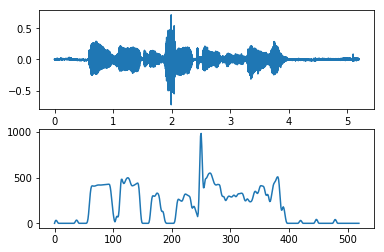

In [6]:
pitch_track = extract_max(pitches, pitches.shape)
pitch_smoothtrack = smooth(pitch_track, window_len=10)
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, wave)
plt.subplot(2, 1, 2)
plt.plot(pitch_smoothtrack)
plt.show()

In [7]:
frame_idxs = np.where( (rms > 0.1) | (zrc > 0.5) )[0]

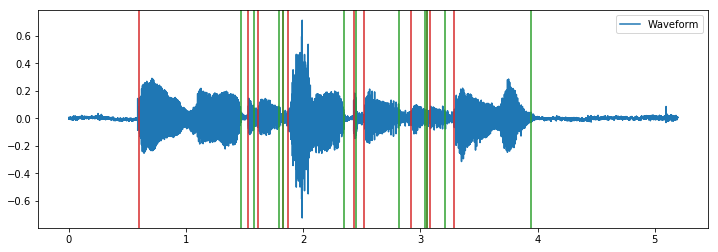

In [11]:
def getboundaries(frame_idxs):
    start_idxs = [frame_idxs[0]]
    end_idxs = []

    shapeofidxs = np.shape(frame_idxs)
    for i in range(shapeofidxs[0]-1):
        if (frame_idxs[i + 1] - frame_idxs[i]) != 1:
            end_idxs.append(frame_idxs[i])
            start_idxs.append(frame_idxs[i+1])

    end_idxs.append(frame_idxs[-1])
    # del the last boundaries if it is both start point and end point.
    if end_idxs[-1] == start_idxs[-1]:
        end_idxs.pop()
        start_idxs.pop()
    assert len(start_idxs) == len(end_idxs), 'Error! Num of start_idxs doesnt match Num of end_idxs.'
    start_idxs = np.array(start_idxs)
    end_idxs = np.array(end_idxs)
    start_t = start_idxs * frame_shift / fs
    end_t = end_idxs * frame_shift / fs
    return start_t, end_t

start_t, end_t = getboundaries(frame_idxs)


plt.figure(figsize=(12, 4))
t = np.linspace(0, len(wave)/fs, len(wave))
plt.plot(t, wave, label='Waveform')
for s, e in zip(start_t, end_t):
    plt.axvline(x=s, color='#d62728') # red vertical line
    plt.axvline(x=e, color='#2ca02c') # green vertical line
plt.legend(loc='best')
plt.show()